### Check differentiability of the code!

This notebook checks that the differentiability of the code.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import grad, jit, vmap
# import jaxopt

config.update("jax_enable_x64", True)

True


model params:

In [2]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
final, all = signal_model.run(initial_signal, signal_model.nmax, None)
final = jnp.sin(2*jnp.pi*signal_model.x) 


In [3]:
forward_model_params = ConfigDict(KDV_params_2)
forward_model_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
forward_model = ETD_KT_CM_JAX_Vectorised(signal_params)

# Randomly initialize the initial conditions for the forward model
key = jax.random.PRNGKey(0)
random_initial_conditions = initial_signal + 0.1*jnp.sin(8*jnp.pi*signal_model.x) 

# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.nmax, None)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
grad_loss_fn = grad(loss_fn)

# Perform gradient descent to minimize the loss
learning_rate = 0.001
num_iterations = 10
optimized_initial_conditions = random_initial_conditions
for i in range(num_iterations):
    loss = loss_fn(optimized_initial_conditions)
    print(f"Iteration {i}, Loss: {loss}")
    gradients = grad_loss_fn(optimized_initial_conditions)
    optimized_initial_conditions -= learning_rate * gradients

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 9.595245452868511
Iteration 1, Loss: 9.594527935709007
Iteration 2, Loss: 9.593810509939779
Iteration 3, Loss: 9.593093168507618
Iteration 4, Loss: 9.592375904540315
Iteration 5, Loss: 9.591658711340656
Iteration 6, Loss: 9.590941582380722
Iteration 7, Loss: 9.590224511296343
Iteration 8, Loss: 9.589507491881887
Iteration 9, Loss: 9.588790518085126


In [4]:
# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
@jit
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.nmax, None)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
@jit
def compute_gradients(initial_conditions):
    return grad(loss_fn)(initial_conditions)

# Perform gradient descent to minimize the loss
@jit
def optimize(initial_conditions, learning_rate):
    gradients = compute_gradients(initial_conditions)
    updated_conditions = initial_conditions - learning_rate * gradients
    loss = loss_fn(updated_conditions)
    return updated_conditions, loss

# Initialize variables for optimization
optimized_initial_conditions = random_initial_conditions
learning_rate = 0.001
num_iterations = 10
# Optimization loop
for i in range(num_iterations):
    optimized_initial_conditions, loss = optimize(optimized_initial_conditions, learning_rate)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 9.594527935709007
Iteration 1, Loss: 9.593810509939775
Iteration 2, Loss: 9.59309316850762
Iteration 3, Loss: 9.592375904540315
Iteration 4, Loss: 9.591658711340656
Iteration 5, Loss: 9.590941582380722
Iteration 6, Loss: 9.590224511296343
Iteration 7, Loss: 9.589507491881882
Iteration 8, Loss: 9.588790518085123
Iteration 9, Loss: 9.58807358400246


In [5]:
import optax
# Define the optimizer
learning_rate = 0.001
optimizer = optax.adam(learning_rate)

# Initialize the optimizer state
opt_state = optimizer.init(random_initial_conditions)
num_iterations = 1000
# Optimization loop using Adam
optimized_initial_conditions = random_initial_conditions

for i in range(num_iterations):
    loss, gradients = jax.value_and_grad(loss_fn)(optimized_initial_conditions)
    updates, opt_state = optimizer.update(gradients, opt_state)
    optimized_initial_conditions = optax.apply_updates(optimized_initial_conditions, updates)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 9.59524545286851
Iteration 1, Loss: 9.58686025762773
Iteration 2, Loss: 9.578462363619181
Iteration 3, Loss: 9.57005079298921
Iteration 4, Loss: 9.561624374393576
Iteration 5, Loss: 9.553181787323501
Iteration 6, Loss: 9.544721616761208
Iteration 7, Loss: 9.536242417260011
Iteration 8, Loss: 9.5277427783665
Iteration 9, Loss: 9.519221379414871
Iteration 10, Loss: 9.510677028024267
Iteration 11, Loss: 9.502108684787068
Iteration 12, Loss: 9.493515478265337
Iteration 13, Loss: 9.484896713038799
Iteration 14, Loss: 9.47625187474211
Iteration 15, Loss: 9.467580639269078
Iteration 16, Loss: 9.45888289247698
Iteration 17, Loss: 9.450158757426728
Iteration 18, Loss: 9.441408615521143
Iteration 19, Loss: 9.43263310831713
Iteration 20, Loss: 9.42383311737106
Iteration 21, Loss: 9.415009727762197
Iteration 22, Loss: 9.406164181324186
Iteration 23, Loss: 9.397297823273632
Iteration 24, Loss: 9.388412049197312
Iteration 25, Loss: 9.37950827025752
Iteration 26, Loss: 9.3705879133

In [ ]:
plt.figure(figsize=(12, 6))

# Plot random initial conditions
plt.plot(initial_signal[0] , label='Signal Model', linestyle='-')
plt.plot(random_initial_conditions[0], label='Random Initial Conditions', linestyle='--',marker='x')

# Plot optimized initial conditions
plt.plot(optimized_initial_conditions[0], label='Optimized Initial Conditions', linestyle='-',marker='o')

plt.title('Comparison of Initial Conditions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

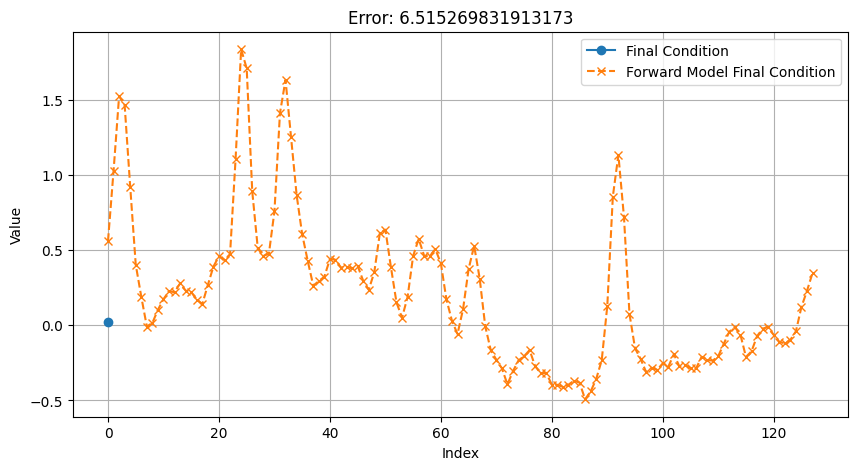

In [6]:
new_initial_conditions = optimized_initial_conditions
# Run the forward model with the optimized initial conditions
forward_final, all_rerun = signal_model.run(new_initial_conditions, forward_model.nmax, None)

plt.figure(figsize=(10, 5))
plt.plot(final[0], label='Final Condition', linestyle='-', marker='o')
plt.plot(forward_final[0], label='Forward Model Final Condition', linestyle='--', marker='x')
plt.title('Final Condition')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Error: ' + str(jnp.linalg.norm(forward_final - final)))
plt.show()